# BRIEF ACP

In [1]:
"""
FUNCTIONS TO REUSE
"""
def quick_view(X):
    title("Dataframe")
    kv("shape", X.shape)
    if VERBOSE > 0:
        display(X)
    
def scale(X, cols = None):
    if not cols:
        cols = X.columns.to_list()
    sc = StandardScaler()
    X[cols] = sc.fit_transform(X[cols])
    title("Standard Scaler")
    if VERBOSE > 0:
        display(X)
    
def build_acp(X):
    acp = PCA(svd_solver='full')
    print(acp)
    coord = acp.fit_transform(X)
    #nombre de composantes calculées
    print(acp.n_components_)
    print(acp.explained_variance_)
    eigval = (n-1)/n*acp.explained_variance_
    print(eigval)
    print(acp.singular_values_**2/n)
    print(acp.explained_variance_ratio_)
    return acp, eigval, coord

def scree_plot(eigval):
    plt.plot(numpy.arange(1,p+1),eigval)
    plt.title("Scree plot")
    plt.ylabel("Eigen values")
    plt.xlabel("Factor number")
    plt.show()
    
def var_and_factors(acp):
    plt.plot(numpy.arange(1,p+1),numpy.cumsum(acp.explained_variance_ratio_))
    plt.title("Explained variance vs. # of factors")
    plt.ylabel("Cumsum explained variance ratio")
    plt.xlabel("Factor number")
    plt.show()
    
def baton_brisee(eigval, coord):
    bs = 1/numpy.arange(p,0,-1)
    bs = numpy.cumsum(bs)
    bs = bs[::-1]
    print(pandas.DataFrame({'Val.Propre':eigval,'Seuils':bs}))
    cf = pandas.DataFrame(coord,index=X.index,columns=numpy.arange(1,p+1))
    print(cf)
    
def show_fact_plan(coord):
    fig, axes = plt.subplots(figsize=(12,12))
    axes.set_xlim(-6,6)
    axes.set_ylim(-6,6)
    for i in range(n):
        plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
    for i in range(n):
        plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
    plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
    plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
    plt.show()
    
    
#pour calculer l'inertie provoquer par un individu on met son score au carré
def inertia(X, coord, eigval):
    title("Inertie")
    di = numpy.sum(X**2,axis=1)
    print(pandas.DataFrame({'ID':X.index,'d_i':di}))
    cos2 = coord**2
    for j in range(p):
        cos2[:,j] = cos2[:,j]/di
    print(pandas.DataFrame({'id':X.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))
    print(numpy.sum(cos2,axis=1))

def get_weight(X, coord, acp):
    title("Poids sur les axes")
    ctr = coord**2
    for j in range(p):
        ctr[:,j] = ctr[:,j]/(n*eigval[j])
    print(pandas.DataFrame({'id':X.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))
    print(numpy.sum(ctr,axis=0))
    print(acp.components_)
    
def get_corr(X, eigval, acp):
    p = X.shape[1]
    sqrt_eigval = numpy.sqrt(eigval)
    corvar = numpy.zeros((p,p))
    for k in range(p):
        corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
    #afficher la matrice des corrélations variables x facteurs    
    print(corvar)
    #on affiche pour les deux premiers axes
    print(pandas.DataFrame({'id':X.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

# 1 Introduction

### D'après http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_ACP_Python.pdf

# 2 Données

Nous  reprenons  la  trame  du  didacticiel  pour  R  [TUTO_R].  Les  données  proviennent  de l’ouvrage de Gilbert Saporta (2006;  tableau  17.1,  page  428)  qui  fait  référenceen  analyse  de données.  Il  s’agit  de  résumer  l’information  contenue  dans  un  fichier  décrivant  (n  =  18) véhicules à l’aide de (p=6) variables.

Disposant des résultats par ailleurs [Saporta, pages 177 et suivantes; TUTO_R; ACP]1, nous pourrons étalonner nos sorties à chaque étape. En effet, appliquer l’outil PCA sur les données pour obtenir les coordonnées factorielles des individus et des variables(vecteurs propres)est relativement  simple.  Les  difficultés  commencent  avec  la  production  des éléments d’aide à l’interprétation  (COS²  et  CTR  des  individus  et  variables,  cercle  des  corrélations),et  le traitement des individus et variables illustratifs. Il faudra mettre un peu la main à la pâte. On se  rend  compte  que  Python est  parfaitement outillé  et  souple  pour  réaliser  une étudecomplète, équivalente à ce que l’on pourrait obtenir sous R avec des packages performants.Il faut savoir exploiter les résultats intermédiaires fournis par PCA simplement.

# 3 ACP et aide à l'interprétation

## 3.1 Importation des données actives

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy

#version
print(pandas.__version__)

#chargement de la première feuille de données
X = pandas.read_excel("auto.xlsx",sheet_name=0,header=0,index_col=0)

1.2.4


Nous remarquons que:

    • Le fichier est un classeur Excel nommé «autos_acp_pour_python.xlsx»;

    • Les données actives sont situées dans la première feuille (sheet_name = 0);

    • La première ligne correspond aux noms des variables (header = 0)

    • La première colonne aux identifiants des observations (index_col =0).Nous  affichons  la  dimension  dela  matrice, nous récupérons le nombre d’observations (n = 18) et de variables (p = 6), enfin nous affichons les valeurs mêmes.

Nous affichons la dimension de la matrice, nous récupérons le nombre d’observations (n =
18) et de variables (p = 6), enfin nous affichons les valeurs mêmes.

In [3]:
#dimension
print(X.shape)

#nombre d'observations
n = X.shape[0]

#nombre de variables
p = X.shape[1]

#affichagedes données
print(X)

(18, 6)
                  CYL  PUISS  LONG  LARG  POIDS  V_MAX
Modele                                                
Alfasud TI       1350     79   393   161    870    165
Audi 100         1588     85   468   177   1110    160
Simca 1300       1294     68   424   168   1050    152
Citroen GS Club  1222     59   412   161    930    151
Fiat 132         1585     98   439   164   1105    165
Lancia Beta      1297     82   429   169   1080    160
Peugeot 504      1796     79   449   169   1160    154
Renault 16 TL    1565     55   424   163   1010    140
Renault 30       2664    128   452   173   1320    180
Toyota Corolla   1166     55   399   157    815    140
Alfetta-1.66     1570    109   428   162   1060    175
Princess-1800    1798     82   445   172   1160    158
Datsun-200L      1998    115   469   169   1370    160
Taunus-2000      1993     98   438   170   1080    167
Rancho           1442     80   431   166   1129    144
Mazda-9295       1769     83   440   165   1095    165
Op

## 3.2 Préparation des données

Nous devons explicitement centrer et réduire les variables pour réaliser une ACP normée
avec PCA. Nous utilisons la classe StandardScaler pour ce faire. Ici aussi, il est important de
vérifier la version de ‘’scikit-learn’’ utilisée.

In [4]:
#scikit-learn
import sklearn
#vérification de la version
print(sklearn.__version__)

0.24.1


Nous instancions l’objet et nous l’appliquons sur la matrice X. Nous obtenons une matrice Z
𝑧𝑖𝑗 =
𝑥𝑖𝑗 − 𝑥̅𝑗
𝜎𝑗
Où 𝑥̅𝑗 =
1
𝑛
∑ 𝑥𝑖𝑗
𝑛
𝑖=1
est la moyenne de la variable Xj, 𝜎𝑗 = √
1
𝑛
∑ (𝑥𝑖𝑗 − 𝑥̅𝑗)²
𝑛
𝑖=1
son écart-type.

In [5]:
#classe pour standardisation
from sklearn.preprocessing import StandardScaler

#instanciation
sc = StandardScaler()

#transformation–centrage-réduction
Z = sc.fit_transform(X)
print(Z)

[[-0.77509889 -0.28335818 -1.88508077 -1.09734528 -1.56900676  0.56976043]
 [-0.12016326  0.01963869  1.60580955  2.0010414   0.23416142  0.14597168]
 [-0.92920139 -0.83885242 -0.44217944  0.25819889 -0.21663062 -0.53209032]
 [-1.12733318 -1.29334771 -1.00072189 -1.09734528 -1.11821472 -0.61684807]
 [-0.12841875  0.67613189  0.25599862 -0.51639778  0.19659542  0.56976043]
 [-0.9209459  -0.13185975 -0.20945342  0.45184806  0.0087654   0.14597168]
 [ 0.45221746 -0.28335818  0.72145067  0.45184806  0.60982146 -0.36257482]
 [-0.18345536 -1.49534562 -0.44217944 -0.71004695 -0.51715865 -1.54918332]
 [ 2.84080623  2.19111619  0.86108628  1.22644473  1.81193359  1.84112668]
 [-1.28143568 -1.49534562 -1.60580955 -1.87194195 -1.98223281 -1.54918332]
 [-0.16969621  1.23162613 -0.25599862 -0.90369611 -0.14149861  1.41733793]
 [ 0.45772112 -0.13185975  0.53526985  1.03279556  0.60982146 -0.02354382]
 [ 1.0080872   1.53462299  1.65235475  0.45184806  2.18759363  0.14597168]
 [ 0.99432805  0.67613189

Vérifions, par acquit de conscience, les propriétés du nouvel ensemble de données. Les
moyennes sont maintenant nulles (aux erreurs de troncature près) :

In [6]:
#vérification -librairie numpy
import numpy
#moyenne
print(numpy.mean(Z,axis=0))

[-2.22044605e-16 -1.41861831e-16  0.00000000e+00  1.86270752e-15
  5.73615229e-16  5.55111512e-16]


Et les écarts-type unitaires.

In [7]:
#écart-type
print(numpy.std(Z,axis=0,ddof=0))

[1. 1. 1. 1. 1. 1.]


Nous sommes maintenant parés pour lancer l’ACP.

## 3.3 Analyse en composantes principales avec PCA de scikit-learn

### 3.3.1 Instanciation et lancement des calculs

Il faut instancier l’objet PCA dans un premier temps, nous affichons ses propriétés.

In [8]:
#classe pour l'ACP
from sklearn.decomposition import PCA
#instanciation
acp = PCA(svd_solver='full')

In [9]:
#affichage des paramètres
print(acp)

PCA(svd_solver='full')


Le paramètre (svd_solver = ‘full’) indique l’algorithme utilisé pour la décomposition en
valeurs singulières. Nous choisissons la méthode ‘’exacte’’, sélectionnée de toute manière par
défaut pour l’appréhension des bases de taille réduite. D’autres approches sont disponibles
pour le traitement des grands ensembles de données. Le nombre de composantes (K) n’étant
pas spécifié (n_components = None), il est par défaut égal au nombre de variables (K = p).
Nous pouvons lancer les traitements dans un second temps. La fonction fit_transform()
renvoie en sortie les coordonnées factorielles Fik que nous collectons dans la variable coord
[TUTO_R, page 4 pour lancer l’ACP, page 7 pour la récupération du champs $scores des
coordonnées factorielles]. Nous affichons le nombre de composantes générées (K), il est bien
égal à p = 6.

In [10]:
#calculs
coord = acp.fit_transform(Z)
#nombre de composantes calculées
print(acp.n_components_)

6


### 3.3.2 Valeurs propres et scree plot

La   propriété .explained_variance_semble  faire  l’affaire  pour  obtenir  les  variances (valeurs propres, λk) associées aux axes factoriels.

In [11]:
#variance expliquée
print(acp.explained_variance_)

[4.68090853 0.90641889 0.39501114 0.22650574 0.09826011 0.04583676]


Patatras... nous n’avons pas les mêmes valeurs que sous R [TUTO_R,  page  5].  Je  me  suis rendu compte qu’il faut appliquer une correction.

In [12]:
#valeur corrigée
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[4.42085806 0.85606229 0.37306608 0.21392209 0.09280121 0.04329027]


Là,tout rentre dans l’ordre [TUTO_R, page 5; ACP, page 23].

Nous  aurions  pu  obtenir  les  bonnes  valeurs  propres  en  passant  par  les  valeurs  singulières .singular_values_issues de la factorisation de la matrice des données centrées et réduites [ACP, page 20]

In [13]:
#ou bien en passant par les valeurs singulières
print(acp.singular_values_**2/n)

[4.42085806 0.85606229 0.37306608 0.21392209 0.09280121 0.04329027]


PCA fournit également les proportions de variance associées aux axes. Il n’est pas nécessaire d’effectuer une correction dans ce cas.

In [14]:
#proportion de variance expliquée
print(acp.explained_variance_ratio_)

[0.73680968 0.14267705 0.06217768 0.03565368 0.01546687 0.00721505]


La  première  composante  accapare  73.68%  de l’information disponible. Il y a un fort ‘’effet taille’’ dans nos données[ACP,  page  55].Nous  disposons  de  87.94%  avec  les  deux  premiers facteurs. Les suivants semblent anecdotiques.
Nous disposons des éléments permettant de construire le graphique ‘’Scree plot’’ (éboulis des valeurs propres)(Figure 2).

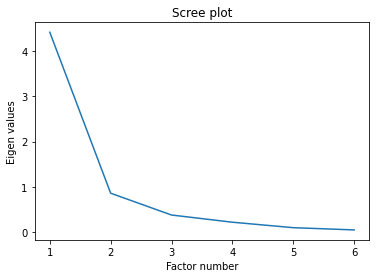

In [15]:
#scree plot
plt.plot(numpy.arange(1,p+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

Le graphique du cumul de variance restituée selon le nombre de facteurs peut être
intéressant également (Figure 3).

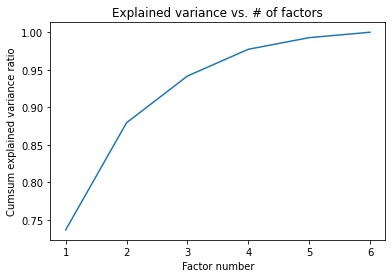

In [16]:
#cumul de variance expliquée
plt.plot(numpy.arange(1,p+1),numpy.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

### 3.3.3 Détermination du nombre de facteur à retenir

Les ‘’cassures’’ dans les graphiques ci-dessus (Figure 2, Figure 3) sont souvent évoquées
(règle du coude) pour identifier le nombre de facteurs K* à retenir. La solution (K* = 2)
semble s’imposer ici.
D’autres pistes existent pour répondre à cette question toujours délicate qui conditionne
l’interprétation de l’ACP, notamment le « test des bâtons brisés » de Legendre & Legendre
(1983) [ACP, page 25 ; voir aussi « ACP avec R – Détection du nombre d’axes », Juin 2012].
Les seuils sont définis par :
𝑏𝑘 = ∑
1
𝑚
𝑝
𝑚=𝑘
Le facteur n°k est validé si (λk > bk), où λk est la valeur propre associée à l’axe n°k.
Calculons ces seuils :

In [17]:
#seuils pour test des bâtons brisés
bs = 1/numpy.arange(p,0,-1)
bs = numpy.cumsum(bs)
bs = bs[::-1]

Puis affichons conjointement les valeurs propres et les seuils :

In [18]:
#test des bâtons brisés
print(pandas.DataFrame({'Val.Propre':eigval,'Seuils':bs}))

   Val.Propre    Seuils
0    4.420858  2.450000
1    0.856062  1.450000
2    0.373066  0.950000
3    0.213922  0.616667
4    0.092801  0.366667
5    0.043290  0.166667


Avec cette procédure, seul le premier facteur est valide. Le cercle des corrélations que nous
construirons par la suite (Figure 5) semble aller dans le même sens.
Néanmoins, par commodité (pas seulement en réalité, cette étude est plus subtile qu’elle n’en
a l’air [ACP, page 39]), nous choisissons K* = 2 pour pouvoir représenter les individus et les
variables dans le plan.

### 3.3.4 Représentation des individus – Outils pour l’interprétation

Coordonnées factorielles. Les coordonnées factorielles (Fik) des individus ont été
collectées dans la variable coord (Section 3.3.1). Nous les positionnons dans le premier plan
factoriel avec leurs labels pour situer et comprendre les proximités entre les véhicules.
Je ferai deux commentaires au préalable :
1. L’ajout d’une étiquette dans un graphique nuage de points n’est pas très pratique sous
Python (librairie Matplotlib), ma solution a le mérite de fonctionner, je ne sais pas s’il y a
plus simple (j’ai cherché pourtant).
2. Les outils graphiques calculent souvent automatiquement les échelles en fonction des
plages de valeurs. Ce n’est pas une bonne idée en ce qui concerne l’ACP. En effet, les axes
n’ont pas la même importance (% de variance restituée). Pour ne pas fausser la
perception des proximités, il est très important de veiller à ce que les échelles soient
identiques en abscisse et en ordonnée. Respecter cette règle nous dispense de faire afficher les pourcentages de variance portés par les axes. Nous nous rendons compte
directement dans notre graphique que les dispersions des individus sont nettement plus
marquées sur le premier axe, en abscisse (Figure 4).

In [19]:
#coordonnées factorielles des individus
cf = pandas.DataFrame(coord,index=X.index,columns=numpy.arange(1,p+1))
print(cf)


                        1         2         3         4         5         6
Modele                                                                     
Alfasud TI      -2.138924  1.785681  0.571862  0.201927 -0.301357  0.053921
Audi 100         1.561459 -1.527040  1.315271 -0.211352  0.148516 -0.327238
Simca 1300      -1.119385 -0.674505  0.456588 -0.167626 -0.375364  0.271803
Citroen GS Club -2.573742  0.112884  0.148570 -0.017343  0.226853  0.263476
Fiat 132         0.427855  0.695567 -0.193286 -0.627754  0.263505 -0.037153
Lancia Beta     -0.304238 -0.196149  0.675803 -0.555941 -0.445086  0.200083
Peugeot 504      0.683928 -0.933057 -0.256823  0.203134  0.208652  0.153892
Renault 16 TL   -1.948493 -0.980448 -0.619575  0.630319  0.293165  0.108642
Renault 30       4.409735  1.063633 -0.593528  0.847248 -0.374890  0.043997
Toyota Corolla  -3.985782  0.236240 -0.303133  0.265122  0.278428 -0.328892
Alfetta-1.66     0.437658  1.912448  0.024942 -0.758910  0.168103 -0.054241
Princess-180

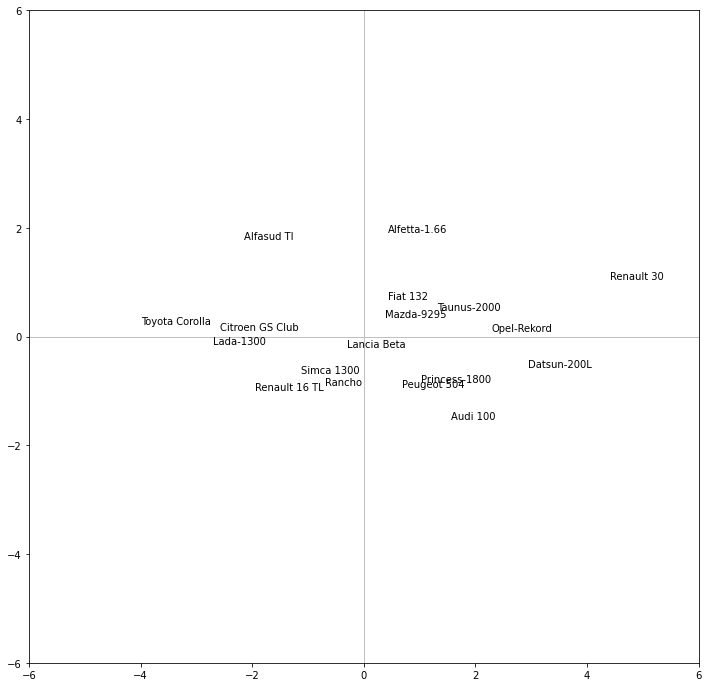

In [20]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6)
axes.set_ylim(-6,6)

for i in range(n):
    plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
    
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)

#affichage
plt.show()

Qualité de représentation – Les COS² (cosinus carré). Pour calculer la qualité de
représentation des individus sur les axes, nous devons d’abord calculer les carrés des
distances à l’origine des individus, qui correspondent également à leur contribution dans
l’inertie totale [ACP, page 30 ; TUTO_R, page 9]
𝑑𝑖
2 = ∑𝑧𝑖𝑗
2
𝑝
𝑗=1

In [21]:
#contribution des individus dans l'inertie totale
di = numpy.sum(Z**2,axis=1)
print(pandas.DataFrame({'ID':X.index,'d_i':di}))

                 ID        d_i
0        Alfasud TI   8.225176
1          Audi 100   6.673755
2        Simca 1300   2.159327
3   Citroen GS Club   6.780145
4          Fiat 132   1.169124
5       Lancia Beta   1.134950
6       Peugeot 504   1.512793
7     Renault 16 TL   5.636826
8        Renault 30  21.789657
9    Toyota Corolla  16.290143
10     Alfetta-1.66   4.456770
11    Princess-1800   1.952513
12      Datsun-200L  11.112624
13      Taunus-2000   2.452986
14           Rancho   1.963373
15       Mazda-9295   0.684521
16      Opel-Rekord   6.083119
17        Lada-1300   7.922198


Concrètement, la Renault 30 et la Toyota Corolla sont les deux véhicules qui se démarquent
le plus des autres, et on les retrouve aux deux extrémités du premier axe factoriel qui porte
73.68% de l’information disponible (Figure 4).

Nous pouvons alors déduire la qualité de représentation des individus sur l’axe n°k avec :
𝐶𝑂𝑆𝑖𝑘
2 =
𝐹𝑖𝑘
2
𝑑𝑖

In [22]:
#qualité de représentation des individus - COS2
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di

print(pandas.DataFrame({'id':X.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

#vérifions la théorie - somme en ligne des cos2 = 1
print(numpy.sum(cos2,axis=1))

                 id    COS2_1    COS2_2
0        Alfasud TI  0.556218  0.387670
1          Audi 100  0.365334  0.349406
2        Simca 1300  0.580284  0.210694
3   Citroen GS Club  0.976992  0.001879
4          Fiat 132  0.156579  0.413826
5       Lancia Beta  0.081555  0.033900
6       Peugeot 504  0.309202  0.575488
7     Renault 16 TL  0.673539  0.170535
8        Renault 30  0.892431  0.051920
9    Toyota Corolla  0.975219  0.003426
10     Alfetta-1.66  0.042978  0.820652
11    Princess-1800  0.530947  0.362855
12      Datsun-200L  0.778390  0.028137
13      Taunus-2000  0.704819  0.096496
14           Rancho  0.243273  0.410469
15       Mazda-9295  0.217336  0.185337
16      Opel-Rekord  0.861900  0.001790
17        Lada-1300  0.926052  0.002607
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Les COS² pour les deux premiers facteurs sont affichés [ACP, page 30 ; TUTO_R, page 9]

Conformément à la théorie, pour chaque individu, la somme des COS² sur l’ensemble des
facteurs est égale à 1.
∑𝐶𝑂𝑆𝑖𝑘
2
𝑝
𝑘=1
= 1

In [23]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(numpy.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Contribution des individus aux axes (CTR). Elles permettent de déterminer les
individus qui pèsent le plus dans la définition de chaque facteur.
𝐶𝑇𝑅𝑖𝑘 =
𝐹𝑖𝑘
2
𝑛 × 𝜆�

In [24]:
#contributions aux axes
ctr = coord**2
for j in range(p):
    ctr[:,j] = ctr[:,j]/(n*eigval[j])
    
print(pandas.DataFrame({'id':X.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))

                 id     CTR_1     CTR_2
0        Alfasud TI  0.057493  0.206933
1          Audi 100  0.030640  0.151329
2        Simca 1300  0.015746  0.029525
3   Citroen GS Club  0.083244  0.000827
4          Fiat 132  0.002300  0.031398
5       Lancia Beta  0.001163  0.002497
6       Peugeot 504  0.005878  0.056499
7     Renault 16 TL  0.047711  0.062384
8        Renault 30  0.244369  0.073419
9    Toyota Corolla  0.199640  0.003622
10     Alfetta-1.66  0.002407  0.237357
11    Princess-1800  0.013028  0.045978
12      Datsun-200L  0.108701  0.020292
13      Taunus-2000  0.021727  0.015361
14           Rancho  0.006002  0.052300
15       Mazda-9295  0.001870  0.008233
16      Opel-Rekord  0.065888  0.000707
17        Lada-1300  0.092194  0.001340


Sans surprises, ce sont la Renault 30 et la Toyota Corolla qui sont déterminants pour le
premier axe ; pour le second, nous avons l’Alfetta-1.66, l’Alfasud TI et l’Audi 100.
Les sommes en ligne sont égales à l’unité ici :
∑𝐶𝑇𝑅𝑖𝑘
𝑛
𝑖=1
= 1

In [25]:
#vérifions la théorie
print(numpy.sum(ctr,axis=0))

[1. 1. 1. 1. 1. 1.]


### 3.3.5 Représentation des variables – Outils pour l’aide à l’interprétation

Nous avons besoin des vecteurs propres pour l’analyse des variables. Ils sont fournis par le
champ .components_

In [26]:
#le champ components_ de l'objet ACP
print(acp.components_)

[[ 0.42493602  0.42179441  0.42145993  0.38692224  0.43051198  0.35894427]
 [ 0.12419108  0.41577389 -0.41181773 -0.446087   -0.24267581  0.6198626 ]
 [-0.35361252 -0.18492049  0.06763394  0.60486812 -0.48439601  0.48547226]
 [ 0.80778648 -0.35779199 -0.27975231  0.21156941 -0.30171136 -0.0735743 ]
 [ 0.15158003 -0.29373465  0.73056903 -0.47819008 -0.30455842  0.18865511]
 [-0.05889517 -0.63303302 -0.19029153 -0.10956624  0.5808122   0.45852167]]


Attention, par rapport à R [TUTO_R, page 6], les facteurs sont en ligne, les variables en
colonne. Nous devons en tenir compte pour obtenir les corrélations (variables x facteurs, 𝑟𝑗𝑘)
en les multipliant par la racine carrée des valeurs propres :

In [27]:
#racine carrée des valeurs propres
sqrt_eigval = numpy.sqrt(eigval)

In [28]:
#corrélation des variables avec les axes
corvar = numpy.zeros((p,p))

for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
    
#afficher la matrice des corrélations variables x facteurs    
print(corvar)

[[ 0.89346354  0.1149061  -0.21598347  0.37361508  0.04617627 -0.01225391]
 [ 0.88685803  0.38468911 -0.11294784 -0.16548492 -0.08948124 -0.13171084]
 [ 0.88615477 -0.38102873  0.04131023 -0.12939024  0.22255537 -0.03959265]
 [ 0.81353638 -0.4127359   0.36944822  0.09785447 -0.14567244 -0.0227967 ]
 [ 0.90518746 -0.22453248 -0.29586489 -0.13954667 -0.09277852  0.12084561]
 [ 0.75471037  0.57351941  0.29652226 -0.03402937  0.05747056  0.09540146]]


Les variables sont maintenant en ligne, les facteurs en colonne :

Si l’on s’en tient spécifiquement aux deux premiers facteurs :

In [29]:
#on affiche pour les deux premiers axes
print(pandas.DataFrame({'id':X.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

      id     COR_1     COR_2
0    CYL  0.893464  0.114906
1  PUISS  0.886858  0.384689
2   LONG  0.886155 -0.381029
3   LARG  0.813536 -0.412736
4  POIDS  0.905187 -0.224532
5  V_MAX  0.754710  0.573519


Les signes sont opposés par rapport à R [TUTO_R, page 6]. Mais ce n’est pas un problème, ce
sont les concomitances et oppositions qui comptent. De ce point de vue, les résultats sont
complètement cohérents.
Nous pouvons dessiner maintenant le cercle des corrélations (Figure 5).

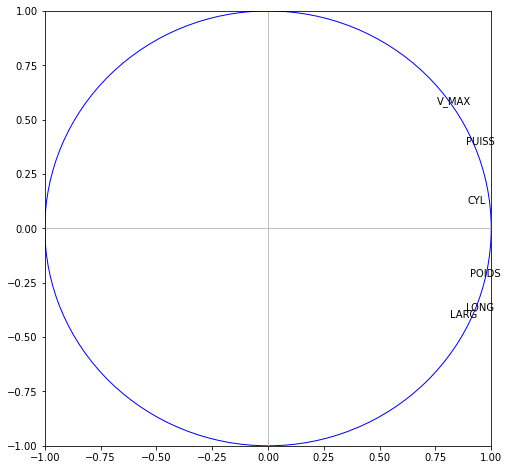

In [30]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

for j in range(p):
    plt.annotate(X.columns[j],(corvar[j,0],corvar[j,1]))
    
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

#affichage
plt.show()

On perçoit clairement l’effet taille sur le premier axe : les voitures puissantes et rapides sont
aussi les plus lourdes et imposantes, la relation globale entre les variables est en réalité
déterminée par la cylindrée (CYL).
Qualité de représentation des variables (COS²). On peut calculer la qualité de
représentation des variables en montant la corrélation au carré : 𝐶𝑂𝑆𝑗𝑘
2 = 𝑟𝑗𝑘
2
[TUTO_R, page
6 ; ACP, page 27]

In [31]:
#cosinus carré des variables
cos2var = corvar**2
print(pandas.DataFrame({'id':X.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

#vérification de la théorie
print(numpy.sum(cos2var,axis=1))

      id    COS2_1    COS2_2
0    CYL  0.798277  0.013203
1  PUISS  0.786517  0.147986
2   LONG  0.785270  0.145183
3   LARG  0.661841  0.170351
4  POIDS  0.819364  0.050415
5  V_MAX  0.569588  0.328925
[1. 1. 1. 1. 1. 1.]


La somme des COS² en ligne est égale à 1 (la somme des COS² d’une variable sur l’ensemble
des facteurs est égale à 1 ; ∑ 𝐶𝑂𝑆𝑗𝑘
𝑝 2
𝑘=1 = 1).
Contribution des variables aux axes (CTR). La contribution est également basée sur le
carré de la corrélation, mais relativisée par l’importance de l’axe [ACP, page 27]
𝐶𝑇𝑅𝑗𝑘 =
𝑟𝑗𝑘
2
𝜆𝑘

Les sommes en colonnes sont égales à 1 cette fois-ci.

In [32]:
#contributions
ctrvar = cos2var

for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les deux premiers axes
print(pandas.DataFrame({'id':X.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

      id     CTR_1     CTR_2
0    CYL  0.180571  0.015423
1  PUISS  0.177911  0.172868
2   LONG  0.177628  0.169594
3   LARG  0.149709  0.198994
4  POIDS  0.185341  0.058892
5  V_MAX  0.128841  0.384230


# 4 Traitement des individus et variables illustratifs

## 4.1 Individus supplémentaires

Nous souhaitons positionner deux véhicules supplémentaires, des Peugeot, par rapport aux
existantes [TUTO_R, page 14].
Figure 6 - Individus supplémentaires
Nous les chargeons avec read_excel() de Pandas, elles sont situées dans le seconde feuille
du classeur Excel (sheet_name = 1).

In [33]:
#chargement des individus supplémentaires
indSupp = pandas.read_excel("auto.xlsx",sheet_name=1,header=0,index_col=0)
print(indSupp)


                CYL  PUISS  LONG  LARG  POIDS  V_MAX
Modele                                              
Peugeot 604    2664    136   472   177   1410    180
Peugeot 304 S  1288     74   414   157    915    160


Nous devons centrer et réduire les variables des individus supplémentaires à l’aide des
paramètres (moyennes et écarts-type) des données actives ayant servi à construire le repère
factoriel.

In [34]:
#centrage-réduction avec les paramètres des individus actifs
ZIndSupp = sc.transform(indSupp)
print(ZIndSupp)

[[ 2.84080623  2.59511201  1.79199036  2.0010414   2.48812166  1.84112668]
 [-0.94571238 -0.53585556 -0.90763148 -1.87194195 -1.23091273  0.14597168]]


Il ne reste plus qu’à faire calculer par la fonction .transform() leurs coordonnées.

In [35]:
#projection dans l'espace factoriel
coordSupp = acp.transform(ZIndSupp)
print(coordSupp)

[[ 5.56329226  0.33860928 -0.46428878  0.40214608 -0.38981076 -0.08102064]
 [-2.21224139  1.25777905 -0.09304388 -0.35370189  0.648528    0.12473042]]


Et à les représenter dans le premier plan factoriel parmi les observations actives.

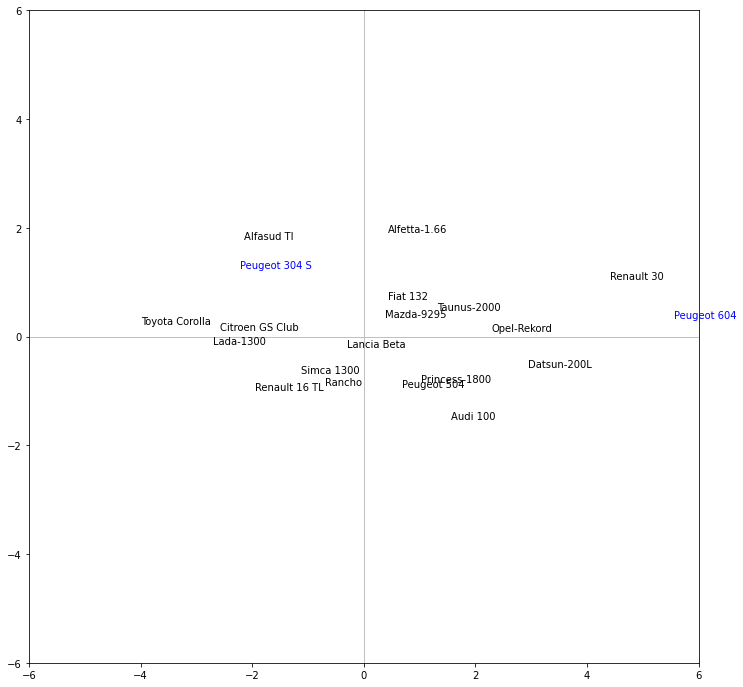

In [36]:
#positionnement des individus supplémentaires dans le premier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6)
axes.set_ylim(-6,6)

for i in range(n):
    plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
    
for i in range(coordSupp.shape[0]):
    plt.annotate(indSupp.index[i],(coordSupp[i,0],coordSupp[i,1]),color='b')

#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)

#affichage
plt.show()

La Peugeot 604 se rapproche plutôt de la Renault 30, la Peugeot 304 de l’Alfasud TI. Pour qui
connaît un peu les voitures de ces années-là, tout cela est parfaitement cohérent.

## 4.2 Variables supplémentaires

Les variables illustratives sont situées dans la troisième feuille du classeur Excel (sheet_name
= 2). Il faut avoir exactement les mêmes observations que les données actives bien
évidemment, ce qui est le cas ici. Nous les importons :

In [37]:
#importation des variables supplémentaires
varSupp = pandas.read_excel("auto.xlsx",sheet_name=2,header=0,index_col=0)
print(varSupp)

                  PRIX  R_POIDS_PUIS FINITION
Modele                                       
Alfasud TI       30570     11.012658      2_B
Audi 100         39990     13.058824     3_TB
Simca 1300       29600     15.441176      1_M
Citroen GS Club  28250     15.762712      1_M
Fiat 132         34900     11.275510      2_B
Lancia Beta      35480     13.170732     3_TB
Peugeot 504      32300     14.683544      2_B
Renault 16 TL    32000     18.363636      2_B
Renault 30       47700     10.312500     3_TB
Toyota Corolla   26540     14.818182      1_M
Alfetta-1.66     42395      9.724771     3_TB
Princess-1800    33990     14.146341      2_B
Datsun-200L      43980     11.913043     3_TB
Taunus-2000      35010     11.020408      2_B
Rancho           39450     14.112500     3_TB
Mazda-9295       27900     13.192771      1_M
Opel-Rekord      32700     11.200000      2_B
Lada-1300        22100     14.044118      1_M


### 4.2.1 Variables illustratives quantitatives

Nous récupérons les variables quantitatives dans une structure à part.

In [38]:
#variables supplémentaires quanti
vsQuanti = varSupp.iloc[:,:2].values
print(vsQuanti)

[[3.05700000e+04 1.10126582e+01]
 [3.99900000e+04 1.30588235e+01]
 [2.96000000e+04 1.54411765e+01]
 [2.82500000e+04 1.57627119e+01]
 [3.49000000e+04 1.12755102e+01]
 [3.54800000e+04 1.31707317e+01]
 [3.23000000e+04 1.46835443e+01]
 [3.20000000e+04 1.83636364e+01]
 [4.77000000e+04 1.03125000e+01]
 [2.65400000e+04 1.48181818e+01]
 [4.23950000e+04 9.72477064e+00]
 [3.39900000e+04 1.41463415e+01]
 [4.39800000e+04 1.19130435e+01]
 [3.50100000e+04 1.10204082e+01]
 [3.94500000e+04 1.41125000e+01]
 [2.79000000e+04 1.31927711e+01]
 [3.27000000e+04 1.12000000e+01]
 [2.21000000e+04 1.40441176e+01]]


Nous calculons les corrélations de ces variables avec les axes factoriels exprimés par les
coordonnées des observations.

In [39]:
#corrélation avec les axes factoriels
corSupp = numpy.zeros((vsQuanti.shape[1],p))

for k in range(p):
    for j in range(vsQuanti.shape[1]):
        corSupp[j,k] = numpy.corrcoef(vsQuanti[:,j],coord[:,k])[0,1]
        
#affichage des corrélations avec les axes
print(corSupp)

[[ 0.77247524  0.08670844 -0.13389277 -0.22582891 -0.15944978 -0.10254878]
 [-0.58903888 -0.67254512 -0.15017616  0.21365718  0.10162791  0.28999742]]


Nous avons une matrice (2 x p), 2 parce que 2 variables illustratives, p est le nombre total de
composantes générées.

Avec ces nouvelles coordonnées, nous pouvons placer les variables dans le cercle des
corrélations [TUTO_R, page 11].

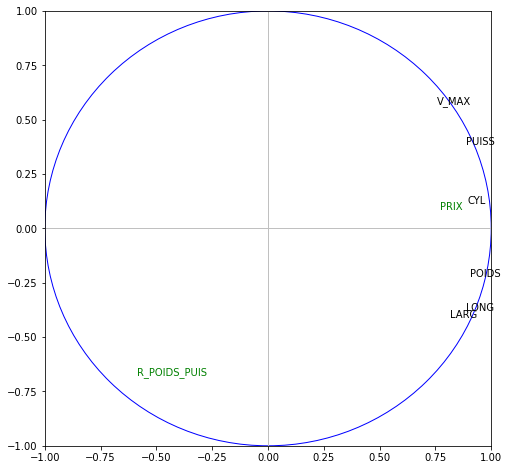

In [40]:
#cercle des corrélations avec les var. supp
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

for j in range(p):
    plt.annotate(X.columns[j],(corvar[j,0],corvar[j,1]))
    
for j in range(vsQuanti.shape[1]):
    plt.annotate(varSupp.columns[j],(corSupp[j,0],corSupp[j,1]),color='g')
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

#affichage
plt.show()

On note dans ce cercle (Figure 9) :
• La variable PRIX est globalement corrélée avec l’ensemble des variables, emportée par la
première composante principale.
• R_POIDS_PUIS (rapport poids-puissance) est quasi-orthogonale au premier facteur. A
bien y regarder, on remarque surtout qu’elle est à l’opposé de V_MAX.

In [41]:
#traitement de var. quali supplementaire
vsQuali = varSupp.iloc[:,2]
print(vsQuali)

Modele
Alfasud TI          2_B
Audi 100           3_TB
Simca 1300          1_M
Citroen GS Club     1_M
Fiat 132            2_B
Lancia Beta        3_TB
Peugeot 504         2_B
Renault 16 TL       2_B
Renault 30         3_TB
Toyota Corolla      1_M
Alfetta-1.66       3_TB
Princess-1800       2_B
Datsun-200L        3_TB
Taunus-2000         2_B
Rancho             3_TB
Mazda-9295          1_M
Opel-Rekord         2_B
Lada-1300           1_M
Name: FINITION, dtype: object


Puis nous récupérons la liste des modalités.

In [42]:
#modalités de la variable qualitative
modalites = numpy.unique(vsQuali)
print(modalites)

['1_M' '2_B' '3_TB']


Nous représentons les individus dans le plan factoriel, coloriées selon la modalité associée de
la variable illustrative. Il y a une petite gymnastique à faire pour obtenir le bon résultat.
J’imagine qu’il est possible de faire plus simple.

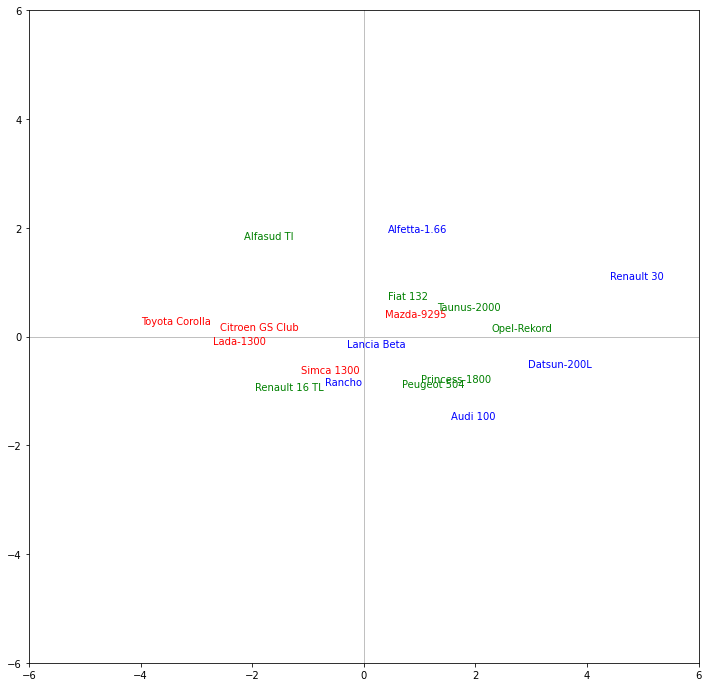

In [43]:
#liste des couleurs
couleurs = ['r','g','b']

#faire un graphique en coloriant les points
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6)
axes.set_ylim(-6,6)

#pour chaque modalité de la var. illustrative
for c in range(len(modalites)):
    #numéro des individus concernés
    numero = numpy.where(vsQuali == modalites[c])
    
    #les passer en revue pour affichage
    for i in numero[0]:
        plt.annotate(X.index[i],(coord[i,0],coord[i,1]),color=couleurs[c])
    #ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)

#affichage
plt.show()

Les couleurs sont définies par la variable couleurs qui est une liste avec les abréviations de
{‘r’ : rouge, ‘v’ : vert, ‘b’ : bleu} pour {1_M, 2_B, 3_TB}.

Puis nous calculons les positions des barycentres conditionnels dans le plan factoriel.

In [44]:
#structure intermédiaire
df = pandas.DataFrame({'Finition':vsQuali,'F1':coord[:,0],'F2':coord[:,1]})

In [45]:
#puis calculer les moyennes conditionnelles
print(df.pivot_table(index='Finition',values=['F1','F2'],aggfunc=pandas.Series.mean))

                F1        F2
Finition                    
1_M      -2.000355 -0.022579
2_B       0.235313  0.045271
3_TB      1.392430 -0.034001


Remarque : Les placer dans le repère factoriel ainsi que calculer les valeurs-test devraient
être relativement simples [TUTO_R, pages 12 et 13].

# 5 Conclusion

Qu’importe le flacon (Tanagra, Excel, R, Python, etc.) pourvu que l’on ait l’ivresse (ACP). Ça
m’a beaucoup amusé de revenir sur un de mes vieux tutoriels pour R pour explorer les
équivalences avec Python. Comme avec princomp(), il m’a fallu un peu de temps pour
explorer les possibilités offertes par PCA de ‘’scikit-learn’’. J’imagine que, à l’instar de R, nous
verrons de plus en plus fleurir de packages pour Python destinés à nous faciliter grandement
la vie pour mener efficacement une analyse en composantes principales avec un minimum de
commandes. Avis aux férus de programmation…

# 6 Références

(ACP) Rakotomalala R., ‘’Analyse en composantes principales – Diapos’’, juillet 2013 ;
http://tutoriels-data-mining.blogspot.com/2013/07/analyse-en-composantes-principales.html
(TUTO_R) Tutoriel Tanagra, ‘’Analyse en composantes principales avec R », Mai 2009 ;
http://tutoriels-data-mining.blogspot.com/2009/05/analyse-en-composantes-principales-avec.html
(SAPORTA) Saporta G., ‘’Probabilités, analyse des données et statistique », Dunod, 2006.
(SKLEARN) ‘’scikit-learn – Machine Learning in Python’’, http://scikit-learn.org/stable/index.html